# Back-Propagation for a Neural Network

This script illustrates how backpropagation can be used to train a neural network by setting a simple binary classification problem using the MNIST dataset. You will be completing portion of the backpropagation algorithm in this notebook. Note that your version of the implementation of the backpropagation algorithm will have a few modifications since the gradients need to aggregate (by summing) the contributions from each training sample.

We begin by loading the necessary packages and generating the data. We set a binary classification in which the number 2 is considered as a positive instance, and all the other digits are considered as negative instances.

In [28]:
# Import tensorflow and other necessary libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [29]:
# Import MNIST data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)

# Getting training and testing data:
# We are setting up just a simple binary classification problem in which we aim to
# properly classify the number 2.
X, y_str = mnist["data"], mnist["target"]
if (not(type(X) is np.ndarray)):
    X = X.to_numpy()
y = np.array([int(int(i)==2) for i in y_str])
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The next cell defines some helper functions.

In [31]:
# Function evaluating the sigmoid
def sigmoid(x):
    return 1/(1+np.exp(-x))

# Function evaluating the derivative of the sigmoid
def sigmoidPrime(x):
    return sigmoid(x)*(1-sigmoid(x))

# Function evaluating the entropy loss
def net_loss(y,yhat):
    y = y.reshape([len(y),1])
    return np.sum(-(1-y)*np.log(1-yhat)-y*np.log(yhat))

# Function to determine the number of mismatches on the prediction
def net_missed(y,yhat):
    y = y.reshape([len(y),1])
    return np.sum(np.abs(y-(yhat>0.5)))

The next portion of the code contains the main functions performing the initialization, training and prediction using the neural network. Your task is to complete the backpropagation function. Make sure all the dimensions are consistent with what was done in class.

In [32]:
# Setting a seed for random number generator
rng = np.random.default_rng(seed=42)

# Function used to initialize the parameters of the neural network
def net_init(net):
    for i in range(1,len(net['struct'])):
        net['W'][i] = 0.001*rng.normal(size=[net['struct'][i],net['struct'][i-1]])
        net['b'][i] = np.zeros([net['struct'][i],1])

# Function used to create the neural network structure. The input is a list
# of parameters corresponding to the length of the input, hidden and output
# layers. The output is a dictionary that contains all the parameters of the
# neuron network.
def net_create(st):
    net = {'struct': st, 'W': {}, 'b': {}, 'a':{}, 'h':{} }
    net_init(net)
    return net

# Function used to evaluate the neural network 
def net_predict(net,X):
    o = np.ones([1,X.shape[0]])
    
    net['h'][0] = np.transpose(X)
    for k in range(0,len(net['W'])):
        net['a'][k+1] = np.matmul(net['b'][k+1],o) + np.matmul(net['W'][k+1],net['h'][k])
        net['h'][k+1] = sigmoid(net['a'][k+1])
        
    return np.transpose(net['h'][len(net['W'])])

# Function using backpropagation to compute the gradients of the parameters
def net_backprop(net,X,y):
    # Performing forward propagation
    yhat = net_predict(net,X)
    # Initializing gradients
    nabla_b = [None]*(len(net['struct']))
    nabla_W = [None]*(len(net['struct']))

    # Implementation of gradients based on backpropagation algorithm
    G = yhat-y.reshape([len(y),1])
    for k in range(len(net['W']),0,-1): 
        # YOUR CODE HERE
      o = np.ones([1,G.shape[0]])
      if k!= len(net['W']):
        G = np.multiply(G,sigmoidPrime(np.transpose(net['a'][k])))
        nabla_W[k] = np.matmul(net['h'][k-1],G)
        nabla_b[k] = np.matmul(o,G)
        G = np.matmul(G,net['W'][k])
      else:
        nabla_W[k] = np.matmul(net['h'][k-1],G)
        nabla_b[k] = np.matmul(o,G)
        G = np.matmul(G,net['W'][k])
    return nabla_b,nabla_W

# Function used for training of the neural network. It updates the parameters
# in the neural network and returns the history of the training Loss 'Loss',
# the validation loss 'Loss_val' and the number of missed prediction in the
# validation set 'missed_val'.
def net_train(net,X_train,y_train,X_val,y_val,epsilon,NIter):
    # Initializing arrays holding the history of loss and missed values
    Loss = np.zeros(NIter)
    Loss_val = np.zeros(NIter)
    missed_val = np.zeros(NIter)
    
    # Simple implementation of gradient descent
    for n in range(0,NIter):
        # Computing gradient and updating parameters
        nabla_b, nabla_W = net_backprop(net,X_train,y_train)
        for k in range(0,len(net['W'])):
            net['b'][k+1] = net['b'][k+1] - epsilon*np.transpose(nabla_b[k+1])
            net['W'][k+1] = net['W'][k+1] - epsilon*np.transpose(nabla_W[k+1])

        # Computing losses and missed values for the validation set
        Loss[n] = net_loss(y_train,np.transpose(net['h'][len(net['W'])]))
        yhat_val = net_predict(net,X_val)
        Loss_val[n] = net_loss(y_val,yhat_val)
        missed_val[n] = net_missed(y_val,yhat_val)

        # Displaying results for the current epoch
        print("... Epoch {:3d} | Loss_Train: {:.2E} | Loss_Val: {:.2E} | Acc_Val: {:2.2f}".format(n,Loss[n],Loss_val[n],100-100*(missed_val[n])/len(yhat_val)))

    return Loss, Loss_val, missed_val

## Checking Single Execution of Gradient Computation

We make sure that the dimensions and values of the gradient are correct for a two layer network.

In [33]:
# Creating a neural network structure
net = net_create([784,100,1])

# Computing gradients
nabla_b, nabla_W = net_backprop(net,X_train,y_train)

In [34]:
# Checking that the number of gradient vectors is correct
assert len(nabla_b)==len(net['struct'])
assert len(nabla_W)==len(net['struct'])

# Checking that the gradients for an index of 0 are still empty. We are just defining them
# to make the indexing similar to what we had for the algorithm. However, they are not used
# in the training.
assert nabla_b[0]==None
assert nabla_W[0]==None

In [35]:
# Checking that the dimensions of the individual gradients are correct
assert len(nabla_b[2])==1
assert nabla_b[1].shape[0]==1
assert nabla_b[1].shape[1]==100
assert nabla_W[1].shape[0]==784
assert nabla_W[1].shape[1]==100
assert nabla_W[2].shape[0]==100
assert nabla_W[2].shape[1]==1

In [36]:
# Checking the values of the gradient
assert np.abs(nabla_b[2]-24080.54)<0.1
assert np.abs(nabla_W[2][50]-10030.44)<0.1

In [37]:
# Checking the values of the gradient
assert np.abs(nabla_b[1][0,50]+0.3647)<1e-3
assert np.abs(nabla_W[1][100,50]+3.4626)<1e-3

Finally, the two networks are fully trained to compare their performance. Note that since we are not doing any hyper-parameter tuning, I am using the test sets for validation to show how the generalization error changes as the network gets trained. If we use this test set as stopping criteria for training then we would need to find a different set for our final evaluation.

... Epoch   0 | Loss_Train: 4.17E+04 | Loss_Val: 4.81E+03 | Acc_Val: 89.68
... Epoch   1 | Loss_Train: 2.87E+04 | Loss_Val: 3.41E+03 | Acc_Val: 89.68
... Epoch   2 | Loss_Train: 2.01E+04 | Loss_Val: 3.30E+03 | Acc_Val: 89.68
... Epoch   3 | Loss_Train: 1.93E+04 | Loss_Val: 3.26E+03 | Acc_Val: 89.68
... Epoch   4 | Loss_Train: 1.91E+04 | Loss_Val: 3.26E+03 | Acc_Val: 89.68
... Epoch   5 | Loss_Train: 1.90E+04 | Loss_Val: 3.23E+03 | Acc_Val: 89.68
... Epoch   6 | Loss_Train: 1.89E+04 | Loss_Val: 3.21E+03 | Acc_Val: 89.68
... Epoch   7 | Loss_Train: 1.88E+04 | Loss_Val: 3.18E+03 | Acc_Val: 89.68
... Epoch   8 | Loss_Train: 1.86E+04 | Loss_Val: 3.11E+03 | Acc_Val: 89.68
... Epoch   9 | Loss_Train: 1.82E+04 | Loss_Val: 3.06E+03 | Acc_Val: 89.68
... Epoch  10 | Loss_Train: 1.79E+04 | Loss_Val: 3.04E+03 | Acc_Val: 89.68
... Epoch  11 | Loss_Train: 1.78E+04 | Loss_Val: 3.03E+03 | Acc_Val: 89.68
... Epoch  12 | Loss_Train: 1.77E+04 | Loss_Val: 2.93E+03 | Acc_Val: 89.68
... Epoch  13 | Loss_Trai

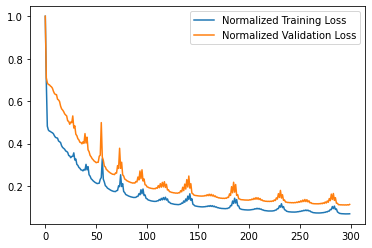

In [38]:
# Training the first network
Loss,Loss_val,missed_val = net_train(net,X_train,y_train,X_test,y_test,epsilon=1e-6,NIter=300)
# Plotting learning curves:
plt.plot(Loss/np.max(Loss))
plt.plot(Loss_val/np.max(Loss_val))
plt.legend({'Normalized Training Loss','Normalized Validation Loss'})
plt.show()

In [39]:
# Checking that the final value of accuracy is correct
assert (100-100*(missed_val[-1])/len(y_test))>98.5